In [2]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
import sklearn
import pysindy as ps
from tools import plot_main

# 数据生成

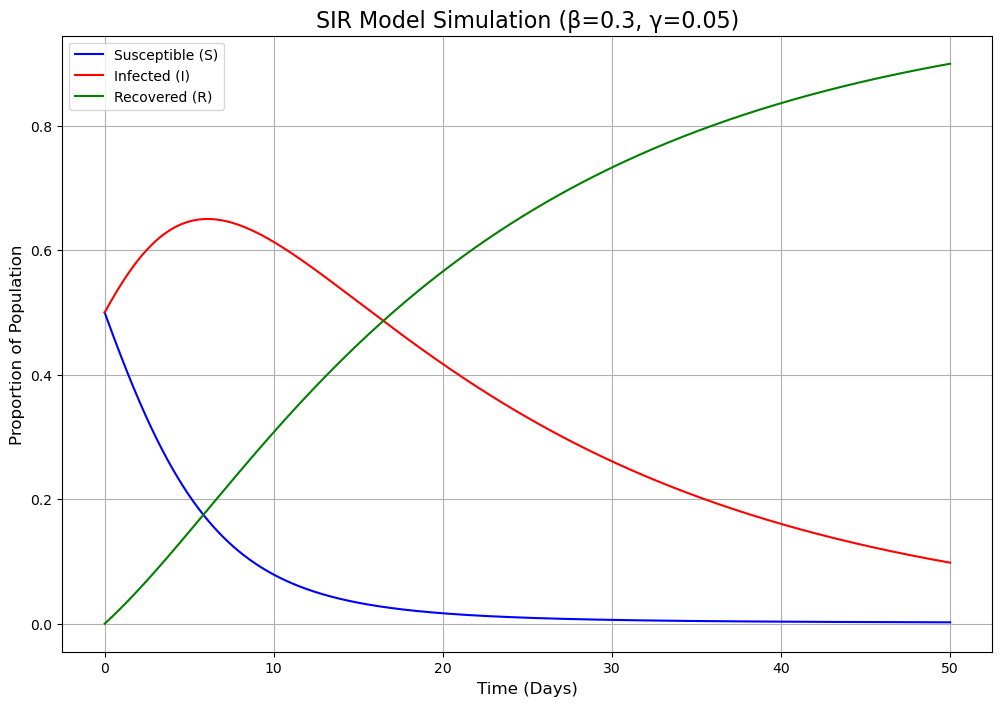

In [21]:
def sir_model_normalized(y, t, beta, gamma):
    """
    归一化SIR模型的微分方程。
    y: 一个包含s, i, r比例的列表或数组
    t: 时间点
    beta: 传染率
    gamma: 康复率
    """
    s, i, r = y
    ds_dt = -beta * s * i
    di_dt = beta * s * i - gamma * i
    dr_dt = gamma * i
    return [ds_dt, di_dt, dr_dt]

# 2. 模型参数和初始条件（保持不变）
initial_infected_ratio = 0.5
initial_recovered_ratio = 0.0
initial_susceptible_ratio = 1.0 - initial_infected_ratio - initial_recovered_ratio

beta = 0.3
gamma = 0.05

y0 = [initial_susceptible_ratio, initial_infected_ratio, initial_recovered_ratio]
total_days = 50
t = np.linspace(0, total_days, total_days*100)
solution = odeint(sir_model_normalized, y0, t, args=(beta, gamma))

data = solution

plt.figure(figsize=(12, 8))

# 2. Plot the S, I, and R curves using the generated data
# solution[:, 0] corresponds to the Susceptible population ratio
# solution[:, 1] corresponds to the Infected population ratio
# solution[:, 2] corresponds to the Recovered population ratio
plt.plot(t, solution[:, 0], 'b-', label='Susceptible (S)')
plt.plot(t, solution[:, 1], 'r-', label='Infected (I)')
plt.plot(t, solution[:, 2], 'g-', label='Recovered (R)')

# 3. Add essential chart elements
plt.title(f'SIR Model Simulation (β={beta}, γ={gamma})', fontsize=16)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Proportion of Population', fontsize=12)
plt.grid(True)  # Add a grid for better readability
plt.legend()    # Display the legend

# 4. Show the final plot
plt.show()

# 拟合

In [6]:
dt=0.01
model = ps.SINDy()
model.fit(data, t=dt)
model.print()

(x0)' = -0.300 x0 x1
(x1)' = 0.000
(x2)' = 0.000


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


In [22]:
#多项式函数
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=1,interaction_only=True)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),#,truncation_param=20
)
# Fit the pipeline
kp.fit(
    data,
    n_inputs=0
)
error = -kp.score(data)
error

np.float64(0.03838979679067564)

In [28]:
# 径向基函数
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('rbf', pykoop.RbfLiftingFn(rbf='gaussian',centers=pykoop.ClusterCenters(estimator=sklearn.cluster.KMeans(n_clusters=5)),shape=0.5)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.1),
)
# Fit the pipeline
kp.fit(
    data,
    n_inputs=0
)
error = -kp.score(data)
error

np.float64(0.06043799773340095)

In [13]:
#kernal，随机傅立叶表征
kp = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rff',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomFourierKernelApprox(
                n_components=24,
                random_state=10,
            )),
    )],
    regressor=pykoop.Edmd(alpha=0.5),
)

kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.07930942051428987)

In [16]:
#延迟嵌入，Hankel
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('delay', pykoop.DelayLiftingFn(n_delays_state=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error


np.float64(0.08357105909849975)

# 矩阵稀疏性

(<Figure size 640x480 with 2 Axes>, <Axes: >)

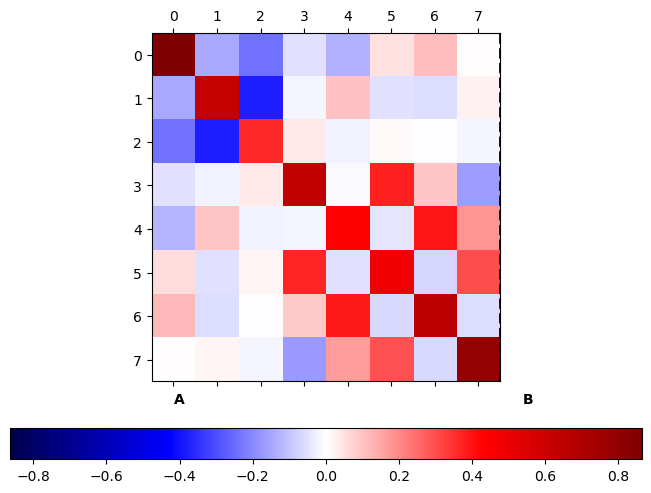

In [29]:
kp.regressor_.plot_koopman_matrix()

In [16]:
def matrix_l1_norm_manual(matrix):
    """
    手动计算矩阵的L1范数（不使用numpy）
    """
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    # 计算每列的绝对值之和
    column_sums = []
    for j in range(cols):
        col_sum = 0
        for i in range(rows):
            col_sum += abs(matrix[i][j])
        column_sums.append(col_sum)
    
    # 返回最大的列和
    return max(column_sums)

A = kp.regressor_.coef_
matrix_l1_norm_manual(A)

np.float64(1.601243074218979)

In [28]:
import numpy as np

def matrix_l0_norm_corrected(matrix, threshold=1e-10):
    """
    计算矩阵的L0范数（各列非零元素数量的最大值）
    
    参数:
    matrix: numpy数组或可以转换为numpy数组的矩阵
    threshold: 阈值，绝对值小于此值的元素视为零
    
    返回:
    l0_norm: 矩阵的L0范数（整数）
    column_norms: 各列的L0范数
    """
    matrix = np.array(matrix, dtype=float)
    
    # 应用阈值：将接近零的元素视为零
    matrix_thresholded = np.where(np.abs(matrix) < threshold, 0, matrix)
    
    # 计算每列的非零元素数量
    column_norms = []
    for col in range(matrix_thresholded.shape[1]):
        non_zero_count = np.count_nonzero(matrix_thresholded[:, col])
        column_norms.append(non_zero_count)
    
    # 矩阵的L0范数是各列L0范数的最大值
    l0_norm = max(column_norms)
    
    return l0_norm

A = kp.regressor_.coef_
matrix_l0_norm_corrected(A,0.05)

1

In [23]:
np.min(A)

np.float64(-0.01992315738463101)

# 真伪特征值

总特征值数量: 8
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (7, [1, 2, 3, 4, 5, 6, 7])
虚假特征值数量 (res > 0.01): 1
残差RES的范围：0.000000 ~ 0.102606


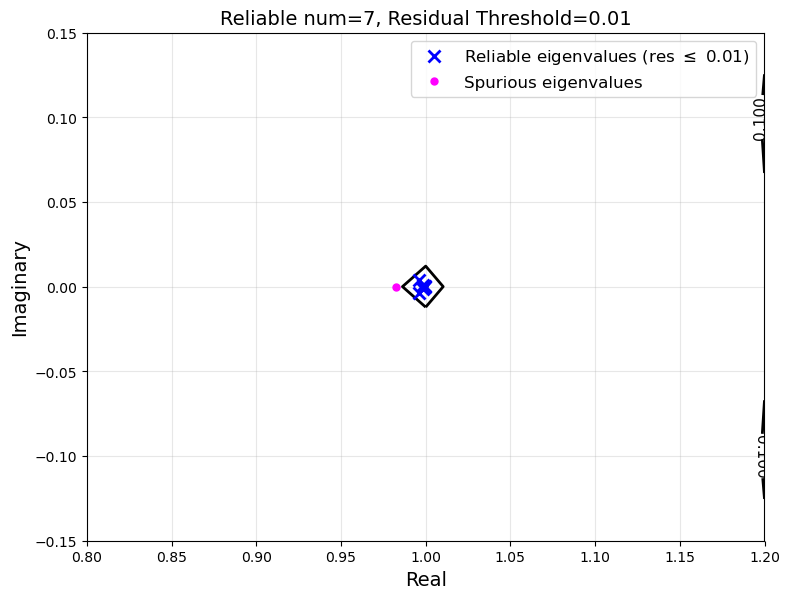

In [17]:
eigenvalues, residuals, reliable_indices = plot_main(kp, data)

# 多步预测

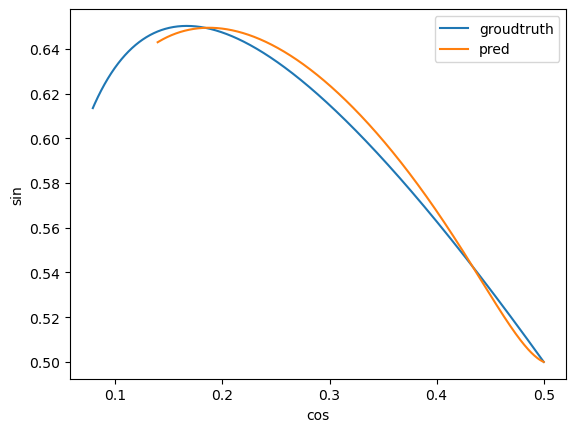

In [18]:
p_steps = 1000
X_test = data[:p_steps,:]
pred = kp.predict_trajectory(X_test,None)
plt.figure()
plt.plot(X_test[:,0],X_test[:,1],label='groudtruth')
plt.plot(pred[:,0],pred[:,1],label='pred')
plt.xlabel('cos')
plt.ylabel('sin')
plt.legend()
plt.show()


# 特征谱与SVD分析

(8, 3)


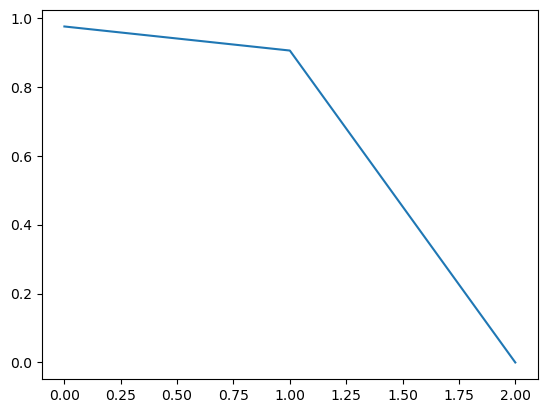

In [31]:
A = kp.regressor_.coef_[:,:3]
print(A.shape)
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(S)
plt.show()

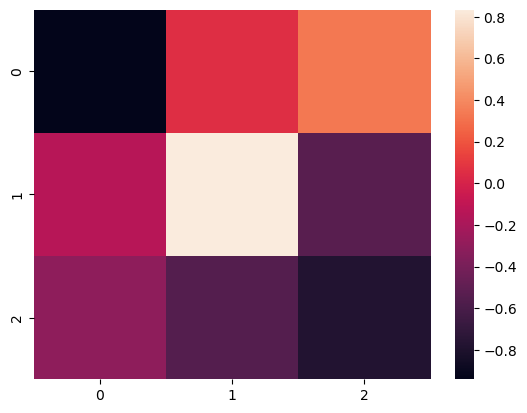

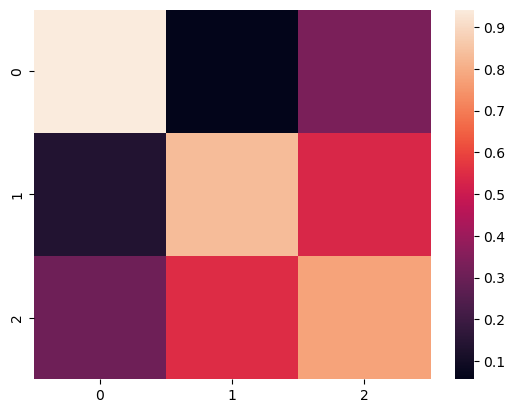

In [32]:
V_abs = np.abs(V)
plt.figure()
sns.heatmap(np.real(V))
plt.show()
plt.figure()
sns.heatmap(V_abs)
plt.show()

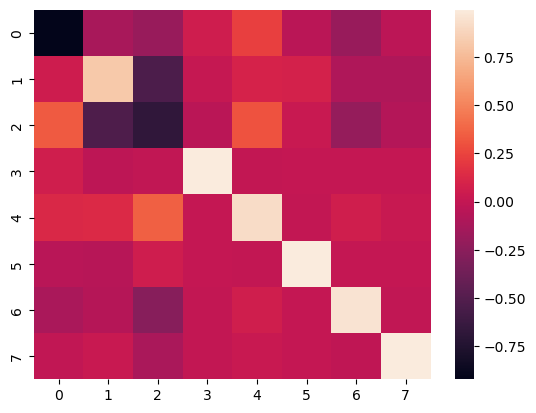

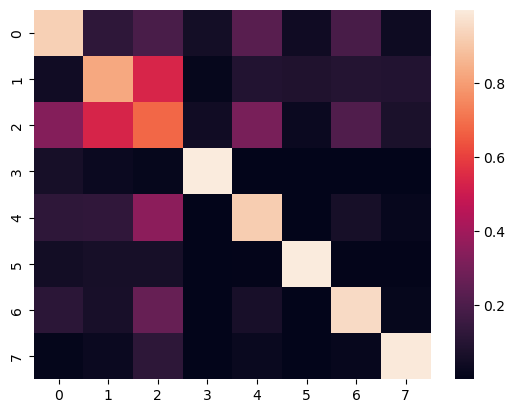

In [33]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

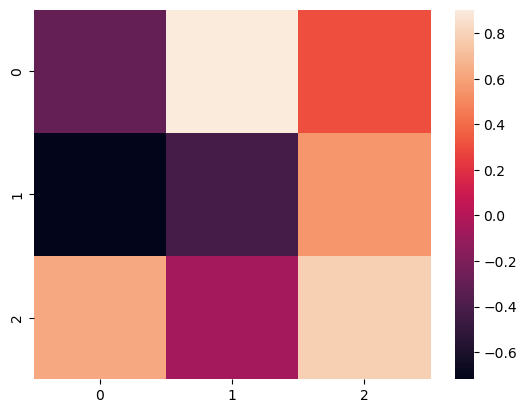

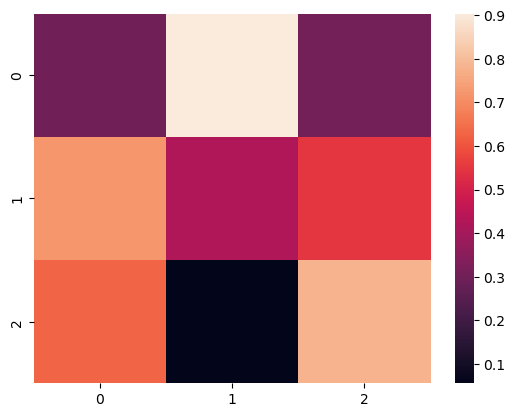

In [20]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

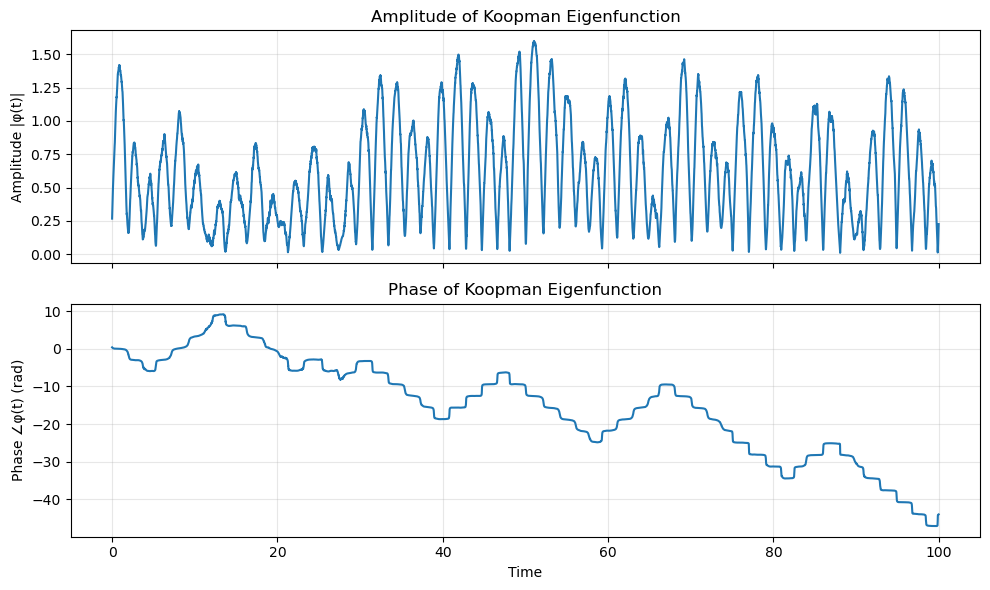

In [436]:
eig_val, left_vecs = np.linalg.eig(A.T)
eig_val, righ_vecs = np.linalg.eig(A)
phi = left_vecs @ kp.lift(X_embed).T

phi_to_plot = phi[0, :]

# 计算幅值和相位
amplitude = np.abs(phi_to_plot)
phase = np.angle(phi_to_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# 1. 绘制幅值
ax1.set_title("Amplitude of Koopman Eigenfunction")
ax1.plot(t, amplitude)
ax1.set_ylabel("Amplitude |φ(t)|")
ax1.grid(True, alpha=0.3)

# 2. 绘制相位 (需要处理跳变)
ax2.set_title("Phase of Koopman Eigenfunction")
ax2.plot(t, np.unwrap(phase)) # np.unwrap() 可以消除-π到π的跳变
ax2.set_ylabel("Phase ∠φ(t) (rad)")
ax2.set_xlabel("Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


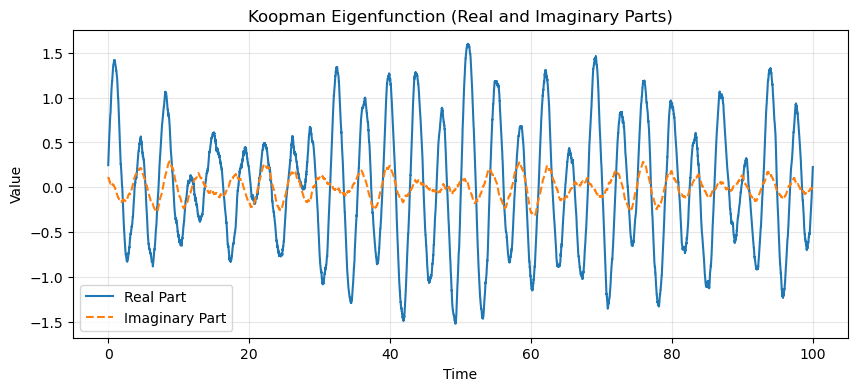

In [437]:
phi_to_plot = phi[0, :] # 选择第一个特征函数

plt.figure(figsize=(10, 4))
plt.title("Koopman Eigenfunction (Real and Imaginary Parts)")
plt.plot(t, np.real(phi_to_plot), label="Real Part")
plt.plot(t, np.imag(phi_to_plot), label="Imaginary Part", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

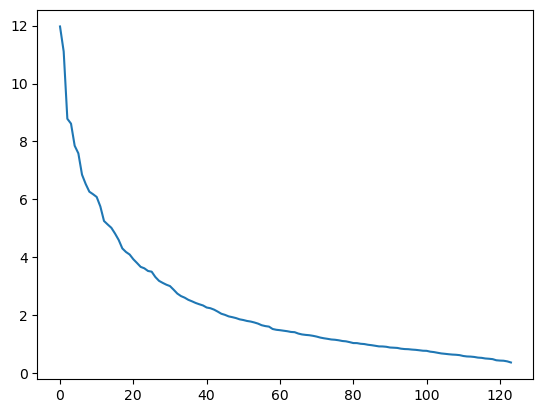

In [410]:
A_ = A @ np.linalg.inv(left_vecs)
U,S,V = np.linalg.svd(A_)
plt.figure()
#plt.plot(np.log(S))
plt.plot(S)
plt.show()

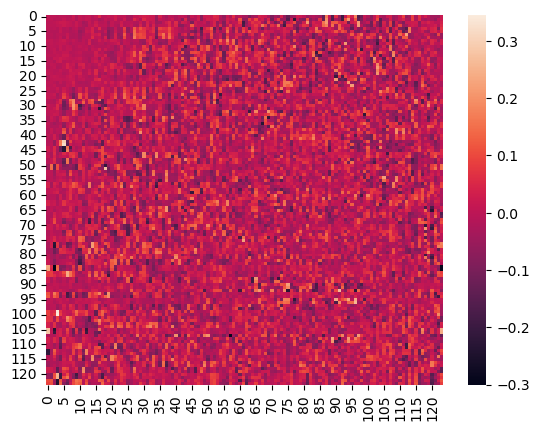

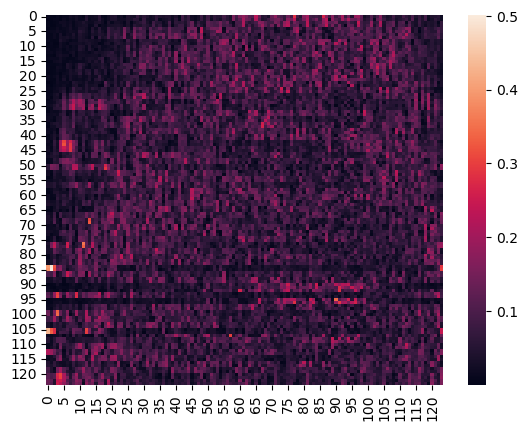

In [330]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

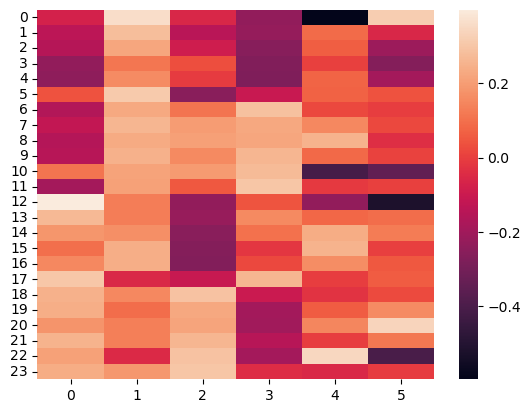

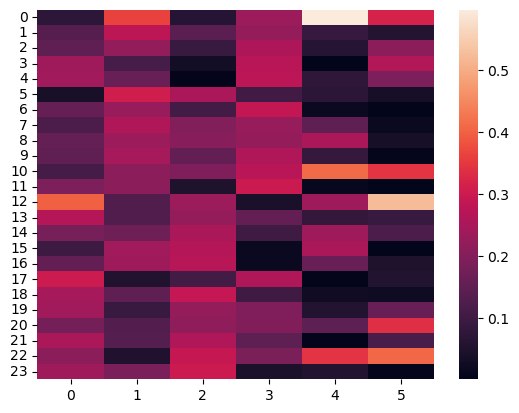

In [280]:
plt.figure()
sns.heatmap(U[:,:6])
plt.show()
plt.figure()
sns.heatmap(U_abs[:,:6])
plt.show()

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf U})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf A})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf B})$'>], dtype=object))

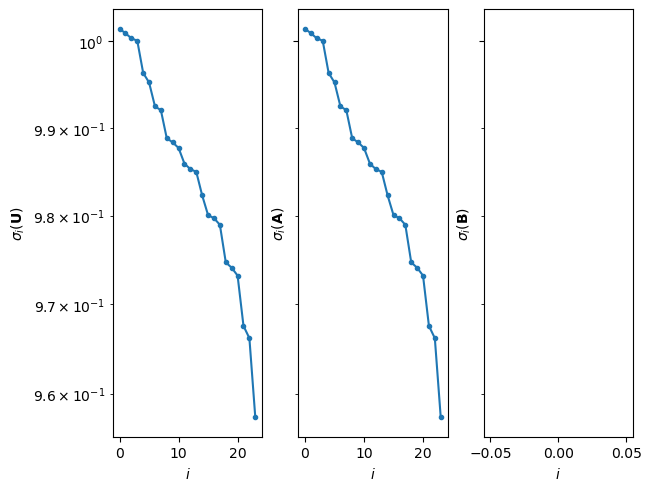

In [386]:
kp.regressor_.plot_svd()

In [128]:
pykoop.lmi_regressors

AttributeError: module 'pykoop' has no attribute 'lmi_regressors'